# Part 1 Bagged Decision Tree

In this homework you are gonna learn 2 things how to use all processor on your machine(in python) and Bagged(Bootstrap Aggregating) Decision Tree.

Bagging(Bootstrap Aggregating) is a common way to prevent overfitting. The idea is to make a bunch of trees. Each with a handicapped data. To handicap the data, one could either use just the subset or just remove some features.

Then after you get a bunch of classifiers(trees) all we need to do is average the output.

Consider the following data write a Bagged Decision Tree out of it.

- For each tree use roughly half the sample (`np.random.choice` is your friend)
- Use minleaf of 20 or so.
- Train 100 trees.
- Make contour plot.

In [1]:
%matplotlib inline
import numpy as np
import math
import pydot
from matplotlib import pyplot as plt
from IPython.display import Image, display
from multiprocessing import Pool
import os
import time
import sys

(-5, 5)

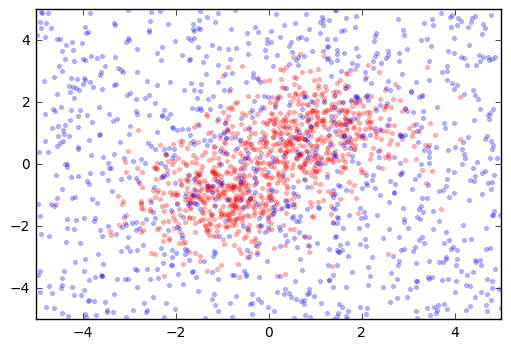

In [2]:
np.random.seed(1234)
nset = 500
xp11 = np.random.randn(nset,1)-1
xp21 = np.random.randn(nset,1)-1

xp12 = np.random.randn(nset,1)+1
xp22 = np.random.randn(nset,1)+1

xp1 = np.concatenate((xp11, xp12))
xp2 = np.concatenate((xp21, xp22))

pcls = np.zeros((nset*2))
pcls[:] = 1

xn1 = np.random.random((nset*2,1))*10-5
xn2 = np.random.random((nset*2,1))*10-5
ncls = np.zeros((1000))
ncls[:] = -1

x1s = np.concatenate([xp1, xn1])
x2s = np.concatenate([xp2, xn2])
cls = np.concatenate([pcls, ncls])
features = np.concatenate((x1s, x2s), axis=1)

cls>0
plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

In [3]:
class Node:
    def __init__(self, msg='label'):
        self.left = None
        self.right = None
        self.msg = msg
        
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def __str__(self):
        return self.msg
    
class DecisionNode(Node):
    def __init__(self,vid=None,cut=None,prob = -1.):
        Node.__init__(self)
        self.vid = vid 
        self.cut = cut
        self.prob = prob
    def classify(self,features):
        if self.is_leaf():
            return self.prob
        if features[self.vid] < self.cut and self.left != None:
            return self.left.classify(features)
        elif features[self.vid] > self.cut and self.right != None:
            return self.right.classify(features)
        
    def __str__(self):
        if not self.is_leaf():
            return "x%d < %.2f"%(self.vid,self.cut)
        else:
            return '%.2f'%self.prob

In [4]:
def make_tree(data):
    features, cls, minleaf = data
    if len(features) < minleaf:
        return DecisionNode(prob = sum(cls>0)/float(len(features)))
    elif len(cls) == sum(cls>0):
        return DecisionNode(prob = 1 if cls[0] > 0 else 0)
    else:
        vid, cut, _, left, featleft, right, featright = find_cut(features, cls)
        node = DecisionNode(vid, cut)
        node.left = make_tree([featleft, left, minleaf])
        node.right = make_tree([featright, right, minleaf])
        return node

In [5]:
def gini(cls):
    p = sum(cls>0) / float(len(cls))
    return p *(1 - p)

def find_cut(features, cls):
    nfeatures = features.shape[1]
    result = []
    for vid in xrange(nfeatures):
        xs = features[:, vid]
        min_, max_ = min(xs), max(xs)
        cuts = np.linspace(min_, max_, 12)[1: - 1]
        for cut in cuts:
            left = cls[xs<cut]
            featLeft = features[xs<cut]
            right = cls[xs>=cut]
            featRight = features[xs>=cut]
            s = gini(left) + gini(right)
            result.append((vid, cut, s, left, featLeft, right, featRight))
    return min(result, key = lambda x: x[2])    

In [6]:
ntree = 100
minleaf = 20
# attempting to use boolean idexing so its cool 
# idx is an array of array ranging from 0 to 1 
idx = np.array([np.array([np.random.randint(2) for i in range(len(features))]) for x in range(ntree)])
ish = np.array([(features[i == 1], cls[i == 1], minleaf) for i in idx])

In [7]:
import time
start_time = time.time()
forest = np.array([make_tree(data) for data in ish])
print("--- %s seconds ---" % (time.time() - start_time))

--- 50.2660000324 seconds ---


In [8]:
def visualize_tree(node, depth_limit=10):
    graph = pydot.Dot(graph_type='digraph')
    visualize_tree_helper(node, graph, 0, depth_limit=depth_limit)
    display(Image(graph.create_png()))
    return graph
    
def visualize_tree_helper(node, graph, depth, depth_limit=10):
    
    if depth > depth_limit:
        print 'Traversing too deep'
        dotnode = pydot.Node('n%d'%id(node), label=str(node), shape="diamond", fillcolor="green", style="filled")
        graph.add_node(dotnode)
        return dotnode
    
    
    if not node.is_leaf():
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="box")
    else:
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="ellipse")
    graph.add_node(dotnode)
    
    if node.left is not None:
        dotleft = visualize_tree_helper(node.left, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotleft, label="Y")
        graph.add_edge(edge)
    if node.right is not None:
        dotright = visualize_tree_helper(node.right, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotright, label="N")
        graph.add_edge(edge)
    return dotnode

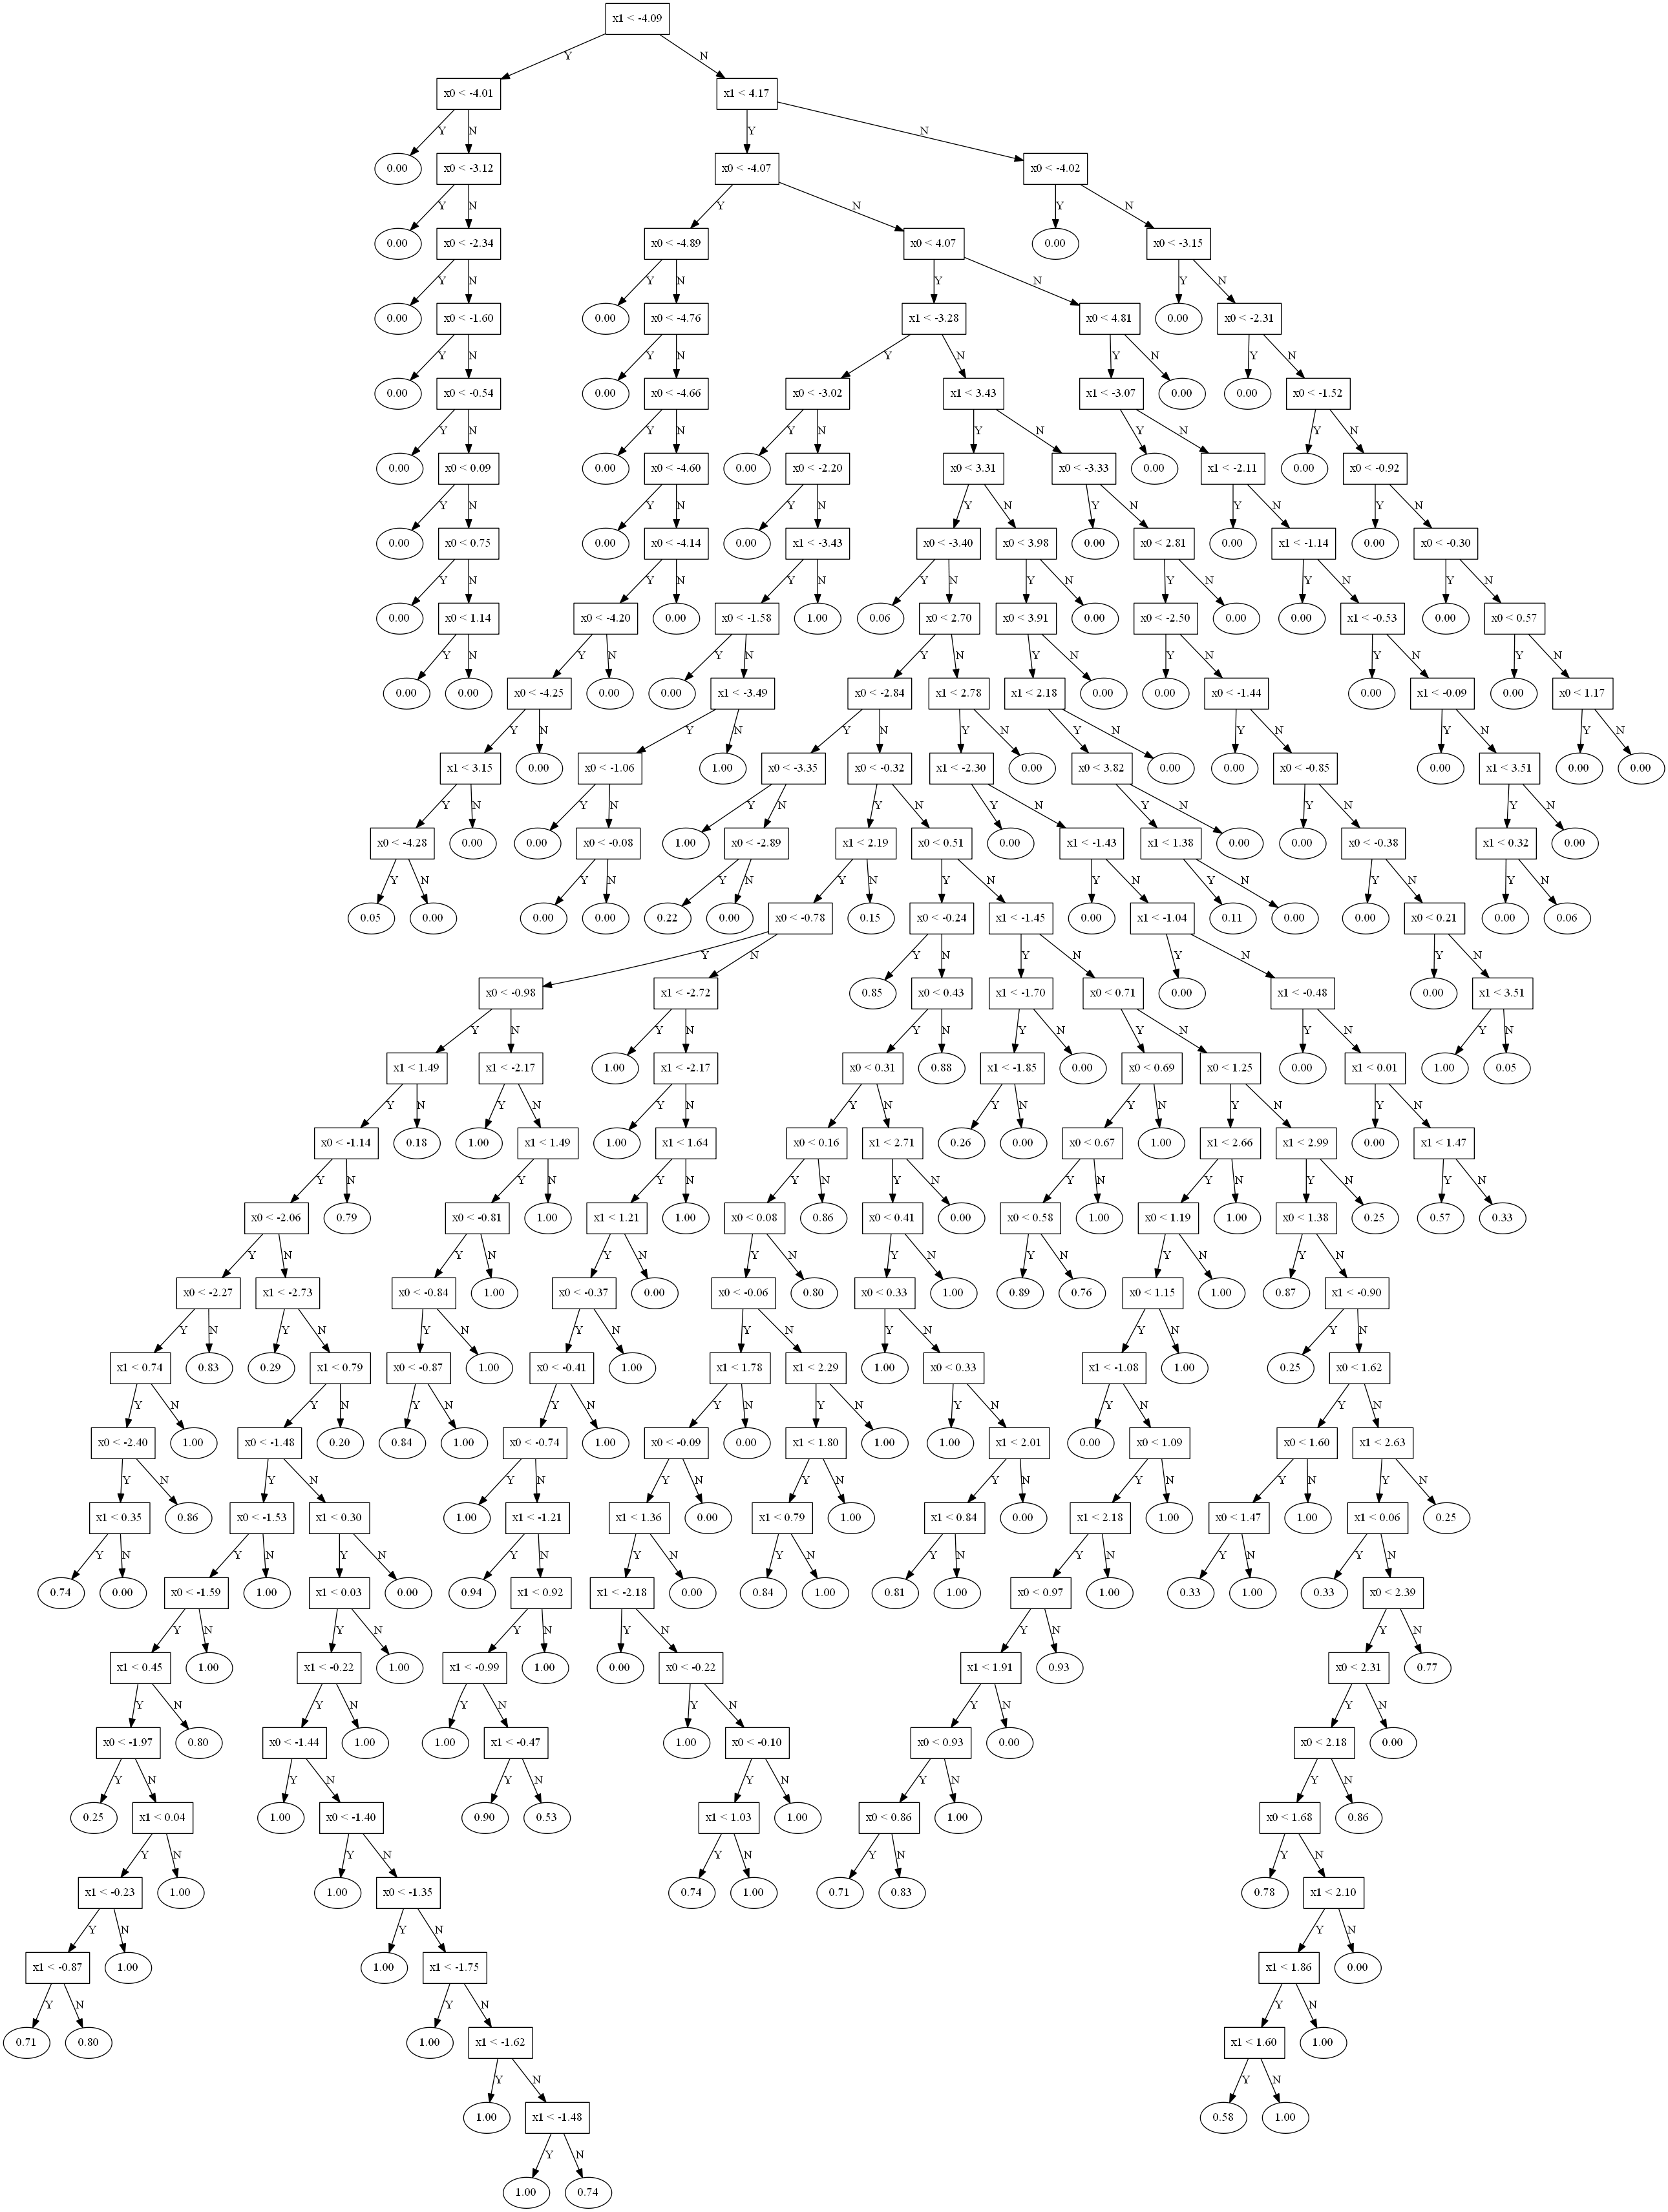

In [10]:
tree = forest[1]
visualize_tree(tree, 30)

# Part 2 Parallelize your code

You can see that training 100 trees takes quite a while. In this problem your job is to modify your code a little bit so that it uses all processor on your machine.

**Save often. There is a chance it will crash your computer.**

https://docs.python.org/2/library/multiprocessing.html

In [ ]:
from multiprocessing import Pool

def f(x):
    return x*x

p = Pool(5)
print(p.map(f, [1, 2, 3]))
p.close()

In [ ]:
start_time = time.time()
p = Pool(100)
pool_forest = p.map(make_tree, ish)
print("--- %s seconds ---" % (time.time() - start_time))

In [12]:
final = [make_tree(i) for i in ish]

(-5, 5)

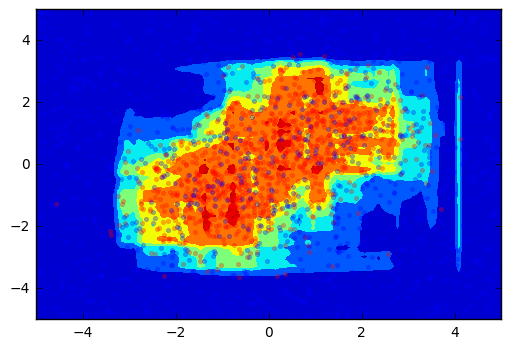

In [15]:
x = np.linspace(-5, 5, 100)
zero_lis = np.zeros((100,100))

for idx1, i in enumerate(x):
    for idx2, j in enumerate(x):
        zero_lis[idx1, idx2] = sum([tree.classify([i, j]) for tree in final])/len(final) # sum / len = avg output 
plt.contourf(x, x, zero_lis.T)

plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)
plt.xlim(-5, 5)
plt.ylim(-5, 5)